In [ ]:
# Install necessary libraries
!pip install tensorflow
!pip install keras
!pip install scikit-learn

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define dataset paths
data_path = '/content/drive/MyDrive/Dataset/Alzheimers-ADNI'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

In [ ]:

# Define image dimensions and batch size
img_size = (224, 224)
batch_size = 32

In [ ]:

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Validation set without data augmentation
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load the training set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1101 images belonging to 5 classes.


In [ ]:
# Load the validation set
valid_generator = valid_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 195 images belonging to 5 classes.


In [ ]:
# Define MobileNet with Transfer Learning
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_mobilenet = models.Sequential()
model_mobilenet.add(base_model_mobilenet)
model_mobilenet.add(layers.GlobalAveragePooling2D())
model_mobilenet.add(layers.Dense(5, activation='softmax'))

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Freeze base model layers
for layer in base_model_mobilenet.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model_mobilenet.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with Transfer Learning
epochs_transfer_learning = 20
history_transfer_learning = model_mobilenet.fit(train_generator, epochs=epochs_transfer_learning, validation_data=valid_generator)

Epoch 1/20
35/35 [==============================] - 317s 9s/step - loss: 1.6868 - accuracy: 0.3533 - val_loss: 1.5332 - val_accuracy: 0.3744
Epoch 2/20
35/35 [==============================] - 76s 2s/step - loss: 1.4736 - accuracy: 0.3906 - val_loss: 1.5105 - val_accuracy: 0.4000
Epoch 3/20
35/35 [==============================] - 86s 2s/step - loss: 1.3791 - accuracy: 0.4487 - val_loss: 1.4797 - val_accuracy: 0.4359
Epoch 4/20
35/35 [==============================] - 77s 2s/step - loss: 1.3377 - accuracy: 0.4469 - val_loss: 1.4446 - val_accuracy: 0.4410
Epoch 5/20
35/35 [==============================] - 74s 2s/step - loss: 1.2977 - accuracy: 0.4832 - val_loss: 1.4281 - val_accuracy: 0.4564
Epoch 6/20
35/35 [==============================] - 76s 2s/step - loss: 1.2817 - accuracy: 0.5068 - val_loss: 1.4363 - val_accuracy: 0.4667
Epoch 7/20
35/35 [==============================] - 75s 2s/step - loss: 1.2342 - accuracy: 0.5168 - val_loss: 1.4282 - val_accuracy: 0.4462
Epoch 8/20
35/35 [=

In [ ]:

# Fine-tune the model
for layer in base_model_mobilenet.layers:
    layer.trainable = True


In [ ]:

# Compile the model for fine-tuning
model_mobilenet.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Save the model
model_mobilenet.save('/content/drive/MyDrive/mobilenet_transfer.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model on test set
test_generator = valid_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important: set shuffle to False for correct evaluation
)

Found 195 images belonging to 5 classes.


In [ ]:
# Evaluate the model
eval_results = model_mobilenet.evaluate(test_generator)
print("Test Accuracy:", eval_results[1])

7/7 [==============================] - 11s 1s/step - loss: 1.3832 - accuracy: 0.4308
Test Accuracy: 0.4307692348957062


In [ ]:
# Get predictions
predictions = model_mobilenet.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

7/7 [==============================] - 10s 1s/step


In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.23      0.29        26
           1       0.53      0.59      0.56        87
           2       0.30      0.50      0.37        36
           3       1.00      0.09      0.17        11
           4       0.38      0.23      0.29        35

    accuracy                           0.43       195
   macro avg       0.52      0.33      0.33       195
weighted avg       0.47      0.43      0.42       195



In [ ]:
# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

Confusion Matrix:
[[ 6 11  8  0  1]
 [ 5 51 23  0  8]
 [ 2 14 18  0  2]
 [ 2  4  2  1  2]
 [ 1 16 10  0  8]]


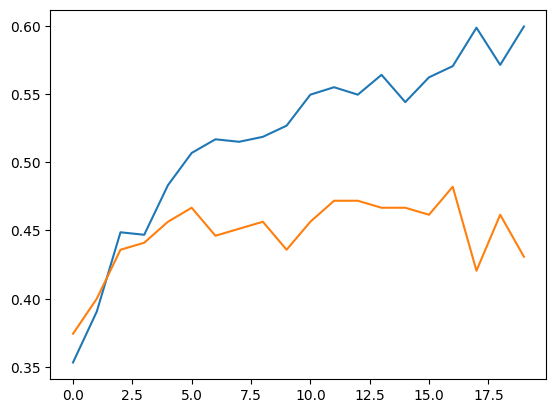

In [ ]:
# Plot training and validation accuracy vs epochs for Transfer Learning
plt.plot(history_transfer_learning.history['accuracy'], label='Training Accuracy (Transfer Learning)')
plt.plot(history_transfer_learning.history['val_accuracy'], label='Validation Accuracy (Transfer Learning)')

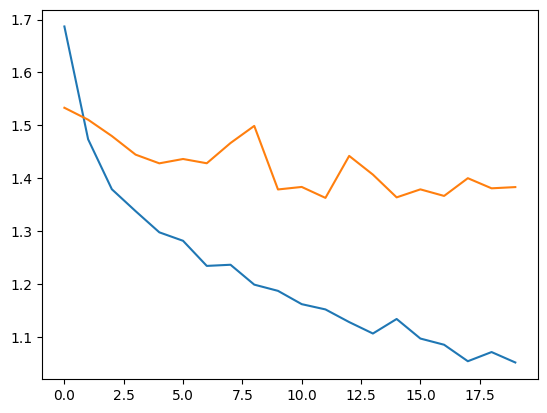

In [ ]:
# Plot training and validation loss vs epochs for Transfer Learning
plt.plot(history_transfer_learning.history['loss'], label='Training Loss (Transfer Learning)')
plt.plot(history_transfer_learning.history['val_loss'], label='Validation Loss (Transfer Learning)')